In [17]:
import xarray as xr
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab
import seaobs.turbulence as turb 
import seaobs.quality as qc
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from xscale.spectral.tools import fit_power_law, plot_power_law 
import numpy as np
import glob
import sitt
from sitt import adcp
#%matplotlib inline
#matplotlib.rcParams['figure.figsize']= (10, 10)
#matplotlib.rcParams['xtick.labelsize']= 14
#matplotlib.rcParams['ytick.labelsize']= 14
#matplotlib.rcParams['axes.labelsize']= 16

In [18]:
from shapely.geometry import Polygon
poly_VAUB = Polygon([[167.1, -22], [165.5, -21], [164.5, -20], [165.5, -20], 
                     [167, -21], [168.5, -22]])

# Useful functions

In [3]:
def plot_transect(raw_data, segments=None, mission_name='',  poly=None, lat_min=-26, lat_max=-16, lon_min=160, lon_max=175):
    """
    Plot ADCP transects from regions of intres
    """
    ax = sitt.plot.add_map(lat_min=lat_min, lat_max=lat_max, lon_min=lon_min, lon_max=lon_max)
    ds_surf = raw_data.isel(depth=0)
    ax.plot(ds_surf.lon, ds_surf.lat, '--', label='Raw data', lw=1)
    section_nb = 1 
    for ds in segments:
        ds_surf = ds.isel(depth=0)
        ax.plot(ds_surf.lon, ds_surf.lat, '.', label='Segment %s' % section_nb, markersize=2)
        section_nb +=1 
    land = cfeature.GSHHSFeature(scale='intermediate', levels=[1], facecolor=cfeature.COLORS['land'])
    if poly is not None:
        ax.add_geometries(poly, ccrs.PlateCarree(), alpha=0.2)
    plt.title(mission_name)
    plt.legend()
    plt.tight_layout()

In [4]:
def store_adcp_segments(segments, output_path, mission_name):
    import pickle
    full_output_path = output_path + mission_name + '/'
    if not os.path.isdir(full_output_path):
        os.makedirs(full_output_path)        
    output_filenames = [full_output_path + mission_name + 
                        '_segment_%02d.nc' % (ns + 1)  for ns in range(len(segments))]
    #for seg, filename in zip(segments, output_filenames):
        #pdb.set_trace()
        #seg.to_netcdf(filename)
    #    pickle.dump(seg, open(filename, "wb"), protocol=-1)
    xr.save_mfdataset(segments, output_filenames)

In [5]:
def plot_uship(raw_data, segments, mission_name='', ax=None):
    if ax is None:
        ax = plt.gca()
    ds_surf = raw_data.isel(depth=0)
    uship = xr.ufuncs.sqrt(ds_surf.uship ** 2 + ds_surf.vship ** 2)
    uship.plot(label='Raw data', ls='--', ax=ax)
    segment_nb = 1
    for ds in segments:
        ds_surf = ds.isel(depth=0)
        uship = xr.ufuncs.sqrt(ds_surf.uship ** 2 + ds_surf.vship ** 2)
        uship.plot(ax=ax)
        segment_nb +=1
    ax.set_ylabel(r'Ship velocity ($m.s^{-1}$)')
    ax.set_title(mission_name)

In [6]:
def plot_heading(raw_data, segments, mission_name='', ax=None):
    if ax is None:
        ax = plt.gca()
    raw_data.isel(depth=0).heading.plot(label='Raw data', ls='--', ax=ax)
    segment_nb = 1
    for ds in segments:
        ds_surf = ds.isel(depth=0)
        ds_surf.heading.plot(ax=ax)
        segment_nb +=1 
    ax.set_ylabel(r'Ship heading ($^{\circ}$)')
    ax.set_title(mission_name)

In [7]:
def monitor_segments(raw_data, segments, output_path, mission_name):
    full_output_path = output_path + '/' + mission_name + '/'
    plt.figure()
    ax1 = plt.subplot(211)
    plot_uship(raw_data, segments, mission_name=mission_name, ax=ax1)
    ax2 = plt.subplot(212)
    plot_heading(raw_data, segments, mission_name=mission_name, ax=ax2)
    plt.tight_layout()
    plt.savefig(full_output_path + mission_name + '_ship_velocity_and_heading.png', dpi=300)
    plt.close()

In [8]:
def plot_segments_on_map(ds, segments, output_path, mission_name, lat_min=-40, lat_max=5, lon_min=150, lon_max=180):
    full_output_path = output_path + mission_name + '/'
    plt.figure()
    plot_transect(ds, segments, mission_name=mission_name, lat_min=lat_min, lat_max=lat_max, lon_min=lon_min, lon_max=lon_max)
    plt.savefig(full_output_path + mission_name + '_segment_map.png', dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.close()

In [9]:
def adcp_data_segmentation(input_path, output_path, mission_name, max_break='10min', max_heading_rate=5,
                           min_length=100, min_observations=50, poly=None):
    """
    Perform a segmentation on the ship sss data
    """
    print("Processing mission %s." % mission_name)  
    try:
        ds = xr.open_dataset(input_path + mission_name + '.nc')
        segments = qc.get_segments(ds, poly=poly, attrs={'mission': mission_name})
        if segments:
            concat_segments = qc.concatenate_segments(segments, max_break=max_break, max_heading_rate=max_heading_rate)
            valid_segments = qc.get_valid_segments(concat_segments, min_length=min_length, min_observations=min_observations)
            if valid_segments:
                qc.save_segments_to_netcdf(valid_segments, output_path, mission_name)
                print("Segmentation of mission %s sucessfully saved." % mission_name)
                monitor_segments(ds, valid_segments, output_path, mission_name)
                plot_segments_on_map(ds, valid_segments, output_path, mission_name, lat_min=-26, lat_max=-16, lon_min=160, lon_max=175)        
                return valid_segments
    except (KeyError, ValueError):
        print("Error processing mission %s." % mission_name)  

In [19]:
# Definition of the different polygon
from shapely.geometry import Polygon
poly_regions = dict()
poly_regions['SCAL'] = Polygon([[162, -23], [171, -23], [171, -27], [162, -27]])
poly_regions['STCC'] = Polygon([[169, -20.5], [169, -24], [180, -24], [180, -20.5]])
poly_regions['VANU'] = Polygon([[169, -20], [166, -20], [162, -18], [162, -12], 
                                [166, -12], [166, -15]])
poly_regions['VAUB'] = Polygon([[167.1, -22], [165.5, -21], [164.5, -20], [165.5, -20], 
                                [167, -21], [168.5, -22]])

In [25]:
import quality as qc
ds = xr.open_dataset('/data/OBS/TSG/LEGOS_CLEAN/sssdata_netcdf_good_3ENY2_20160408_20161016..nc')

In [26]:
segments = qc.get_segments(ds, min_uship=4,
                           max_heading_rate=5,
                           poly=poly_regions['VANU'])

In [27]:
segments

[<xarray.Dataset>
 Dimensions:    (time: 1)
 Coordinates:
   * time       (time) datetime64[ns] 2007-03-25T14:55:00
     lon        (time) float32 162.408
     lat        (time) float32 -17.1098
 Data variables:
     SST        (time) float32 28.127
     SST_QC     (time) float64 0.0
     SST_ERROR  (time) float32 0.5
     SSS        (time) float32 34.827
     SSS_QC     (time) float64 2.0
     SSS_ERROR  (time) float32 -0.024
     uship      (time) float64 -5.091
     vship      (time) float64 1.871
     heading    (time) float32 159.822
 Attributes:
     segment_number:  1, <xarray.Dataset>
 Dimensions:    (time: 71)
 Coordinates:
   * time       (time) datetime64[ns] 2007-03-25T15:05:00 2007-03-25T15:10:00 ...
     lon        (time) float32 162.413 162.416 162.418 162.421 162.424 ...
     lat        (time) float32 -17.14 -17.1552 -17.1698 -17.1855 -17.2012 ...
 Data variables:
     SST        (time) float32 28.131 28.132 28.166 28.166 28.19 28.181 ...
     SST_QC     (time) float64 

In [23]:
concat_segments = qc.concatenate_segments(segments, 
                                          max_break='15min',                                                      
                                          max_heading_rate=5)

IndexError: list index out of range

# Run the segmentation on one example ADCP file

In [12]:
input_path = "/data/OBS/ADCP/clean_data/"
output_path = "/data/OBS/ADCP/test_segments/"
filenames = sorted(os.listdir(input_path))
missions = [f[:-3] for  f in filenames]
max_break='30min'
max_heading_rate=5
min_length=50
min_observations=50
poly = Polygon([[167.1, -22], [165.5, -21],[167, -21], [168.5, -22]])

In [13]:
mission_name ='sprayalis3'
ds = xr.open_dataset(input_path + mission_name + '.nc')

In [14]:
ds

<xarray.Dataset>
Dimensions:  (depth: 56, time: 317)
Coordinates:
  * time     (time) datetime64[ns] 2012-10-01T07:38:44 2012-10-01T07:48:45 ...
  * depth    (depth) float64 24.0 40.0 56.0 72.0 88.0 104.0 120.0 136.0 ...
    nprofs   float64 1.0
Data variables:
    lon      (time) float64 167.1 167.1 167.1 167.1 167.1 167.1 167.1 167.1 ...
    lat      (time) float64 -22.15 -22.11 -22.09 -22.06 -22.03 -22.01 -21.98 ...
    heading  (time) float64 357.0 355.4 357.5 358.3 356.0 356.0 355.8 356.1 ...
    uship    (time) float64 -0.392 -0.394 -0.398 -0.376 -0.383 -0.349 -0.365 ...
    u        (depth, time) float64 -0.015 0.056 -0.036 -0.074 -0.051 0.041 ...
    vship    (time) float64 5.069 5.098 5.032 4.984 4.838 4.812 4.814 4.758 ...
    v        (depth, time) float64 0.237 0.118 0.12 0.151 0.155 0.076 0.045 ...
    e        (depth, time) float64 0.028 0.012 -0.012 0.021 -0.003 0.016 ...
    pg       (depth, time) float64 99.0 99.0 99.0 99.0 100.0 100.0 100.0 ...
    pflag    (depth, ti

In [15]:
%matplotlib inline

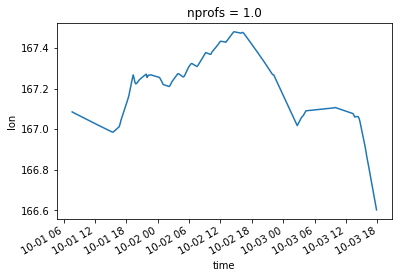

In [16]:
ds.lon.plot()

In [17]:
%pdb off

Automatic pdb calling has been turned OFF


In [18]:
segments = qc.get_segments(ds, poly=poly, attrs={'mission': mission_name})

In [19]:
len(segments)

4

In [20]:
segments[0]

<xarray.Dataset>
Dimensions:  (depth: 56, time: 38)
Coordinates:
  * time     (time) datetime64[ns] 2012-10-01T08:38:44 2012-10-01T08:48:46 ...
  * depth    (depth) float64 24.0 40.0 56.0 72.0 88.0 104.0 120.0 136.0 ...
    nprofs   float64 1.0
Data variables:
    lon      (time) float64 167.1 167.1 167.1 167.1 167.1 167.1 167.1 167.1 ...
    lat      (time) float64 -21.98 -21.96 -21.93 -21.9 -21.88 -21.85 -21.83 ...
    heading  (time) float64 355.8 356.1 356.3 356.6 356.7 356.9 356.3 356.3 ...
    uship    (time) float64 -0.365 -0.369 -0.358 -0.359 -0.379 -0.37 -0.379 ...
    u        (depth, time) float64 0.094 0.03 0.065 0.008 -0.055 -0.05 0.018 ...
    vship    (time) float64 4.814 4.758 4.771 4.796 4.813 4.822 4.868 4.852 ...
    v        (depth, time) float64 0.045 -0.006001 -0.018 0.027 0.059 0.047 ...
    e        (depth, time) float64 -0.003 -0.026 0.017 -0.018 0.034 -0.017 ...
    pg       (depth, time) float64 100.0 99.0 99.0 99.0 100.0 99.0 100.0 ...
    pflag    (depth, t

In [21]:
concat_segments = qc.concatenate_segments(segments, max_break=max_break, max_heading_rate=max_heading_rate)

In [22]:
concat_segments[0]

<xarray.Dataset>
Dimensions:  (depth: 56, time: 38)
Coordinates:
  * depth    (depth) float64 24.0 40.0 56.0 72.0 88.0 104.0 120.0 136.0 ...
    nprofs   float64 1.0
  * time     (time) datetime64[ns] 2012-10-01T08:38:44 2012-10-01T08:48:46 ...
Data variables:
    lon      (time) float64 167.1 167.1 167.1 167.1 167.1 167.1 167.1 167.1 ...
    lat      (time) float64 -21.98 -21.96 -21.93 -21.9 -21.88 -21.85 -21.83 ...
    heading  (time) float64 355.8 356.1 356.3 356.6 356.7 356.9 356.3 356.3 ...
    uship    (time) float64 -0.365 -0.369 -0.358 -0.359 -0.379 -0.37 -0.379 ...
    u        (depth, time) float64 0.094 0.03 0.065 0.008 -0.055 -0.05 0.018 ...
    vship    (time) float64 4.814 4.758 4.771 4.796 4.813 4.822 4.868 4.852 ...
    v        (depth, time) float64 0.045 -0.006001 -0.018 0.027 0.059 0.047 ...
    e        (depth, time) float64 -0.003 -0.026 0.017 -0.018 0.034 -0.017 ...
    pg       (depth, time) float64 100.0 99.0 99.0 99.0 100.0 99.0 100.0 ...
    pflag    (depth, t

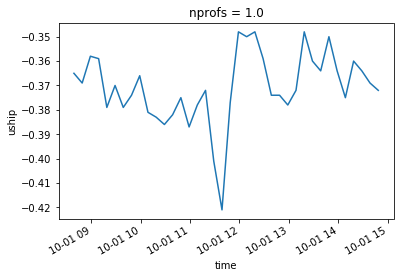

In [23]:
concat_segments[0].uship.plot()

In [24]:
valid_segments = qc.get_valid_segments(concat_segments, min_length=min_length, min_observations=10)

In [25]:
valid_segments = [seg.compute() for seg in valid_segments]

In [26]:
valid_segments[0]

<xarray.Dataset>
Dimensions:  (depth: 56, time: 38)
Coordinates:
  * depth    (depth) float64 24.0 40.0 56.0 72.0 88.0 104.0 120.0 136.0 ...
    nprofs   float64 1.0
  * time     (time) datetime64[ns] 2012-10-01T08:38:44 2012-10-01T08:48:46 ...
Data variables:
    lon      (time) float64 167.1 167.1 167.1 167.1 167.1 167.1 167.1 167.1 ...
    lat      (time) float64 -21.98 -21.96 -21.93 -21.9 -21.88 -21.85 -21.83 ...
    heading  (time) float64 355.8 356.1 356.3 356.6 356.7 356.9 356.3 356.3 ...
    uship    (time) float64 -0.365 -0.369 -0.358 -0.359 -0.379 -0.37 -0.379 ...
    u        (depth, time) float64 0.094 0.03 0.065 0.008 -0.055 -0.05 0.018 ...
    vship    (time) float64 4.814 4.758 4.771 4.796 4.813 4.822 4.868 4.852 ...
    v        (depth, time) float64 0.045 -0.006001 -0.018 0.027 0.059 0.047 ...
    e        (depth, time) float64 -0.003 -0.026 0.017 -0.018 0.034 -0.017 ...
    pg       (depth, time) float64 100.0 99.0 99.0 99.0 100.0 99.0 100.0 ...
    pflag    (depth, t

In [27]:
store_adcp_segments(valid_segments, output_path, mission_name)

In [28]:
monitor_segments(ds, valid_segments, output_path, mission_name)

In [29]:
plot_segments_on_map(ds, valid_segments, output_path, mission_name, lat_min=-26, lat_max=-16, lon_min=160, lon_max=175)        

In [30]:
valid_segments = adcp_data_segmentation(input_path, output_path, , min_length=100)

SyntaxError: invalid syntax (<ipython-input-30-c558a5ce0699>, line 1)

In [ ]:
ds = open_adcp_transect_from_olvac(input_path + '00945v3.nc', chunks={'time': 500})

In [ ]:
heading = compute_heading(ds.lat, ds.lon)

In [ ]:
ds.lon.isel(depth=0).plot()

In [ ]:
ds.heading.isel(depth=0).plot()